# Data Science for Cycling #4 - How to Calculate Route Gradient with Python
- Notebook 4/6
- You'll only need Numpy, Pandas, and Matplotlib to follow along
- Let's import the libraries and tweak Matplotlib's default stylings:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

- Let's read in the dataset
- You'll need the one exported in the previous notebook, as it has elevation and distance data:

In [2]:
route_df = pd.read_csv('../data/route_df_elevation_distance.csv')
route_df.head()

,latitude,longitude,elevation,elevation_diff,distance,cum_elevation,cum_distance
0,45.772480,15.958040,113.96,0.00,0.00,0.00,0.00
1,45.772770,15.959090,115.82,1.86,87.59,1.86,87.59
2,45.773270,15.958795,116.15,0.33,60.12,2.19,147.71
3,45.773770,15.958500,116.12,-0.03,60.12,2.16,207.83
4,45.774235,15.959335,115.98,-0.14,82.87,2.02,290.70


<br>

## How to Calculate Gradient from a Strava Route
- A gradient is nothing but a slope of the surface you're riding on
- Our data is quite limited, as we have only 835 data points spread over 36 kilometers, but let's do our best
- We can estimate the average gradient between two data points by dividing the elevation difference between them with the distance covered and multiplying the result with a 100
- Let's test the logic with hardcoded values from the second data point:

In [3]:
(1.86 / 87.59) * 100

2.1235300833428474

- The average grade from the route start (point 1) to the second data point was 2.1%
- It's only the average, so in the 87 meters we could have 15 meters with 10% grade and the remaining 70 meters completely flat, or the entire 87 meters could be on a 2% incline
- The point is - we can't know for sure, so this logic will have to do

- Let's apply it to the entire dataset:
    - We'll skip the first row, as there's nothing to compare it with
    - Gradients are usually rounded to a single decimal points, like 6.1%

In [4]:
gradients = [np.nan]

for ind, row in route_df.iterrows(): 
    if ind == 0:
        continue
    grade = (row['elevation_diff'] / row['distance']) * 100
    gradients.append(np.round(grade, 1))
    
gradients[:10]

[nan, 2.1, 0.5, -0.0, -0.2, -1.1, 0.8, 1.7, -0.1, -0.5]

- Calculations done - we'll now visualize the average gradient for each of the 835 data points
    - X-axis: individual data point
    - Y-axis: average gradient (%)

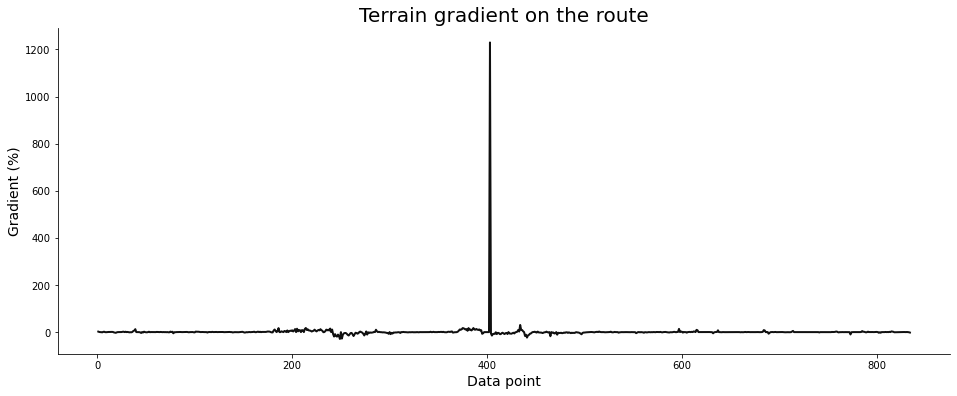

In [5]:
plt.title('Terrain gradient on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
plt.plot(np.arange(len(gradients)), gradients, lw=2, color='#101010');

- There appears to be something wrong with the route file
- A single data point has over 1200% gradient, which isn't possible
    - In theory, that would mean you gain 1200 meters of elevation for 100 meters of distance
- Let's mitigate this issue by adding a condition
    - If the estimated average gradient is greater than 30% (there are no such gradients on this route, and grades above 30% are super rare), we'll append a `NaN` to the list of gradients

In [5]:
gradients = [np.nan]

for ind, row in route_df.iterrows(): 
    if ind == 0:
        continue
        
    grade = (row['elevation_diff'] / row['distance']) * 100
    
    if grade > 30:
        gradients.append(np.nan)
    else:
        gradients.append(np.round(grade, 1))

- It should look a lot better now:

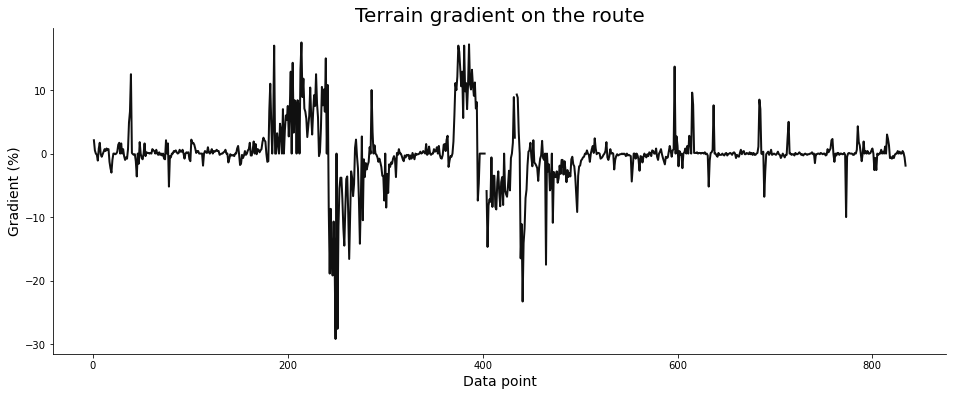

In [6]:
plt.title('Terrain gradient on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
plt.plot(np.arange(len(gradients)), gradients, lw=2, color='#101010');

- Definitely a step in the right directions, but we now have a couple of missing data points
    - Take a look at the previous chart around X value of 400
- We'll need to interpolate these

<br>

## How to Interpolate Incorrect Gradients From a Strava Route
- First things first, let's assign the calculated gradients to a new column in the dataset:

In [7]:
route_df['gradient'] = gradients
route_df.head()

,latitude,longitude,elevation,elevation_diff,distance,cum_elevation,cum_distance,gradient
0,45.772480,15.958040,113.96,0.00,0.00,0.00,0.00,NaN
1,45.772770,15.959090,115.82,1.86,87.59,1.86,87.59,2.1
2,45.773270,15.958795,116.15,0.33,60.12,2.19,147.71,0.5
3,45.773770,15.958500,116.12,-0.03,60.12,2.16,207.83,-0.0
4,45.774235,15.959335,115.98,-0.14,82.87,2.02,290.70,-0.2


- And now let's see where the missing values are:

In [8]:
route_df[route_df['gradient'].isna()]

,latitude,longitude,elevation,elevation_diff,distance,cum_elevation,cum_distance,gradient
0,45.77248,15.95804,113.96,0.00,0.00,0.00,0.00,NaN
403,45.82749,15.85927,239.16,9.47,0.77,125.20,15994.86,NaN
434,45.82166,15.84892,185.34,6.18,20.33,71.38,17232.97,NaN


- We can ignore the first one, as it's missing because there was no way to calculate it
- Let's focus on the second one and isolate it with the surrounding couple of rows:

In [9]:
route_df[401:406]

,latitude,longitude,elevation,elevation_diff,distance,cum_elevation,cum_distance,gradient
401,45.82701,15.859655,229.69,0.00,60.77,115.73,15933.32,0.0
402,45.82749,15.859280,229.69,0.00,60.77,115.73,15994.09,0.0
403,45.82749,15.859270,239.16,9.47,0.77,125.20,15994.86,NaN
404,45.82748,15.859170,238.70,-0.46,7.83,124.74,16002.69,-5.9
405,45.82742,15.858980,236.33,-2.37,16.16,122.37,16018.85,-14.7


- What a simple interpolation would do is replace the missing value with an average of the data point before and after it
- For example, the gradient before the missing value was 0, and after was -5.9
    - (0 + 5.9) / 2 = 2.95
- Our interpolated gradient is 2.95%

In [10]:
route_df[401:406].interpolate()

,latitude,longitude,elevation,elevation_diff,distance,cum_elevation,cum_distance,gradient
401,45.82701,15.859655,229.69,0.00,60.77,115.73,15933.32,0.00
402,45.82749,15.859280,229.69,0.00,60.77,115.73,15994.09,0.00
403,45.82749,15.859270,239.16,9.47,0.77,125.20,15994.86,-2.95
404,45.82748,15.859170,238.70,-0.46,7.83,124.74,16002.69,-5.90
405,45.82742,15.858980,236.33,-2.37,16.16,122.37,16018.85,-14.70


- Let's not apply it to the entire dataset
- We'll also fill the first missng value with 0:

In [12]:
route_df['gradient'] = route_df['gradient'].interpolate().fillna(0)

route_df.head()

,latitude,longitude,elevation,elevation_diff,distance,cum_elevation,cum_distance,gradient
0,45.772480,15.958040,113.96,0.00,0.00,0.00,0.00,0.00
1,45.772770,15.959090,115.82,1.86,87.59,1.86,87.59,2.12
2,45.773270,15.958795,116.15,0.33,60.12,2.19,147.71,0.55
3,45.773770,15.958500,116.12,-0.03,60.12,2.16,207.83,-0.05
4,45.774235,15.959335,115.98,-0.14,82.87,2.02,290.70,-0.17


- One final check:

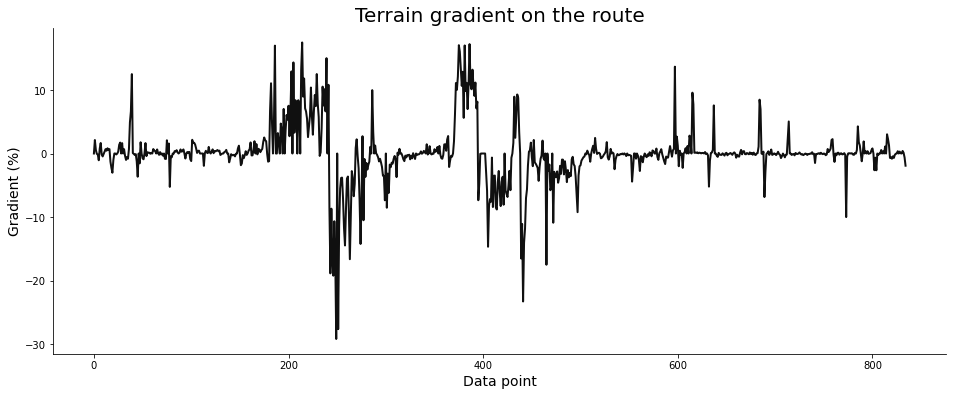

In [13]:
plt.title('Terrain gradient on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
plt.plot(np.arange(len(route_df)), route_df['gradient'], lw=2, color='#101010');

- Everything looks good now, so we can save the dataset to a CSV file
    - You'll need it in the upcoming notebooks:

In [14]:
route_df.to_csv('../data/route_df_gradient.csv', index=False)

- In the next notebook, you'll learn how to analyze the gradient profile of a route
- It will give you a deeper insight of distance cycled in different gradient ranges